In [25]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('test_data.csv')

In [4]:
drop_columns = ['Account_ID', 'Entity_ID',
       'Closure_Type', 'Entity_City', 'Entity_State', 'Entity_Zip',
         'Total_Paid', 'Number_of_payments',
       'Percent_Paid', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s',
       'age_70s', 'age_over_80','Target','Creditor_Name']

In [28]:
data.drop(drop_columns, axis=1, inplace=True)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
Seller_Type                   100000 non-null object
Median_Household_Income       100000 non-null float64
Invoice_bal                   100000 non-null float64
Age                           100000 non-null float64
Income_level                  100000 non-null object
Age_MedIncome                 100000 non-null float64
Invbal_MedIncome              100000 non-null float64
Invbal_Age                    100000 non-null float64
Paid                          100000 non-null int64
unemployment_rate             97912 non-null float64
labor_force_participation     97969 non-null float64
education_highschool          97964 non-null float64
education_college_or_above    97964 non-null float64
home_value                    96886 non-null float64
rent_burden                   95890 non-null float64
Age_range                     100000 non-null object
Unemply_rate_range            100000 

### Converting objects to category datatypes & One-hot-encode our categorical data

In [55]:
# #selecting data types "object" in order to one hot encode
categorical = data.loc[:, (data.dtypes == np.object) | (data.dtypes == np.int64)]

#converting data types to "category"
for col in categorical.columns: 
    categorical[col] = categorical[col].astype('category')

In [64]:
target = categorical.Paid

cat_features = categorical.drop('Paid', axis=1)
one_hot_cat = pd.get_dummies(cat_features)

### Standard scaling our numerical data

In [32]:
from sklearn.preprocessing import StandardScaler, RobustScaler

#RobustScaler is less prone to outliers 

std_scl = StandardScaler()
rob_scl = RobustScaler()

In [34]:
#selecting data types "float"
numerical = data.loc[:, data.dtypes == np.float64]

In [35]:
numerical['scl_Median_Household_Income'] = rob_scl.fit_transform(numerical.Median_Household_Income.values.reshape(-1,1))
numerical['scl_Invoice_bal'] = rob_scl.fit_transform(numerical.Invoice_bal.values.reshape(-1,1))
numerical['scl_Age'] = rob_scl.fit_transform(numerical.Age.values.reshape(-1,1))
numerical['scl_Age_MedIncome'] = rob_scl.fit_transform(numerical.Age_MedIncome.values.reshape(-1,1))
numerical['scl_Unemployment_rate'] = rob_scl.fit_transform(numerical.unemployment_rate.values.reshape(-1,1))
numerical['scl_Labor_force_participation'] = rob_scl.fit_transform(numerical.labor_force_participation.values.reshape(-1,1))
numerical['scl_Education_Highschool'] = rob_scl.fit_transform(numerical.education_highschool.values.reshape(-1,1))
numerical['scl_Education_College'] = rob_scl.fit_transform(numerical.education_college_or_above.values.reshape(-1,1))
numerical['scl_Home_value'] = rob_scl.fit_transform(numerical.home_value.values.reshape(-1,1))
numerical['scl_Rent_burden'] = rob_scl.fit_transform(numerical.rent_burden.values.reshape(-1,1))

In [38]:
num_drop = ['Median_Household_Income', 'Invoice_bal', 'Age', 'Age_MedIncome',
       'Invbal_MedIncome', 'Invbal_Age', 'unemployment_rate',
       'labor_force_participation', 'education_highschool',
       'education_college_or_above', 'home_value', 'rent_burden']

scaled_num = numerical.drop(num_drop, axis=1)
scaled_num.columns

Index(['scl_Median_Household_Income', 'scl_Invoice_bal', 'scl_Age',
       'scl_Age_MedIncome', 'scl_Unemployment_rate',
       'scl_Labor_force_participation', 'scl_Education_Highschool',
       'scl_Education_College', 'scl_Home_value', 'scl_Rent_burden'],
      dtype='object')

In [66]:
#combining numerical and categorical features into one dataset to scale
c = pd.concat([target, one_hot_cat], axis=1, join_axes=[target.index])
#filling NaNs with 0s
c.fillna(0, inplace=True)

In [67]:
c.head()

,Paid,Seller_Type_AMBULANCE,Seller_Type_HOSPITAL,Income_level_0ver_150k,Income_level_100k_to_150k,Income_level_20k_to_25k,Income_level_25k_to_35k,Income_level_35k_to_50k,Income_level_50k_to_75k,Income_level_75k_to_100k,...,Education_highschool_30-35%,Education_highschool_35-40%,Education_highschool_40-45%,Education_highschool_45-50%,Education_highschool_5-10%,Education_highschool_50-55%,Education_highschool_55-60%,Education_highschool_60-65%,Education_highschool_65-70%,Education_highschool_70%+
0,1,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
#combining numerical and categorical features into one dataset to scale
new_df = pd.concat([c, scaled_num], axis=1, join_axes=[c.index])
new_df.fillna(0, inplace=True)

## Random Under-sampling

In [80]:
sample_df = new_df.sample(frac=.3)

payers = sample_df.loc[new_df.Paid ==1]
nonpayers = sample_df.loc[new_df.Paid == 0] 

norm_dist_df = pd.concat([payers, nonpayers])

In [81]:
df = norm_dist_df.sample(5000, random_state=42)
df.Paid.value_counts(normalize=True)

1    0.5202
0    0.4798
Name: Paid, dtype: float64

In [82]:
df.head()

,Paid,Seller_Type_AMBULANCE,Seller_Type_HOSPITAL,Income_level_0ver_150k,Income_level_100k_to_150k,Income_level_20k_to_25k,Income_level_25k_to_35k,Income_level_35k_to_50k,Income_level_50k_to_75k,Income_level_75k_to_100k,...,scl_Median_Household_Income,scl_Invoice_bal,scl_Age,scl_Age_MedIncome,scl_Unemployment_rate,scl_Labor_force_participation,scl_Education_Highschool,scl_Education_College,scl_Home_value,scl_Rent_burden
34435,1,1,0,0,0,0,0,0,1,0,...,0.136771,-0.290920,0.461152,0.537569,-0.227273,-0.186275,0.207207,0.372222,0.596313,0.115789
66777,0,0,1,0,0,0,1,0,0,0,...,-1.325825,0.505028,-0.902484,-1.076471,0.977273,-1.176471,0.819820,-0.638889,-0.811835,-1.073684
93685,0,0,1,0,0,0,0,1,0,0,...,-0.882063,15.803486,-0.857030,-0.920187,0.363636,-0.607843,1.009009,-0.405556,-0.734159,-0.410526
57467,0,0,1,0,0,0,0,0,1,0,...,0.000000,22.511196,0.597516,0.574052,0.590909,-0.637255,-0.216216,0.427778,0.118391,1.126316
49911,1,0,1,0,0,0,1,0,0,0,...,-1.596327,-0.077467,-0.811575,-1.107706,-1.545455,-1.901961,0.441441,-0.661111,-0.625070,-0.136842


In [83]:
#creating features to feed into predictors 
features = df.drop('Paid', axis=1, inplace=False)
#creating target variable (y)
target = df.Paid 
#creating dummies, one-hot encode prior to standardizing 
#predictors = pd.get_dummies(features)

In [84]:
features.columns

Index(['Seller_Type_AMBULANCE', 'Seller_Type_HOSPITAL',
       'Income_level_0ver_150k', 'Income_level_100k_to_150k',
       'Income_level_20k_to_25k', 'Income_level_25k_to_35k',
       'Income_level_35k_to_50k', 'Income_level_50k_to_75k',
       'Income_level_75k_to_100k', 'Income_level_Under_20k', 'Age_range_18-21',
       'Age_range_22-24', 'Age_range_25-29', 'Age_range_30-34',
       'Age_range_35-39', 'Age_range_40-44', 'Age_range_45-49',
       'Age_range_50-54', 'Age_range_55-59', 'Age_range_60-64',
       'Age_range_65-69', 'Age_range_70-74', 'Age_range_75-79',
       'Age_range_80-84', 'Age_range_85-89', 'Age_range_90 +',
       'Unemply_rate_range_0-2.9%', 'Unemply_rate_range_11-14.9%',
       'Unemply_rate_range_15-19.9%', 'Unemply_rate_range_20-29.9%',
       'Unemply_rate_range_3-4.9%', 'Unemply_rate_range_30-39.9%',
       'Unemply_rate_range_40-49.9%', 'Unemply_rate_range_5-6.9%',
       'Unemply_rate_range_50%+', 'Unemply_rate_range_7-8.9%',
       'Unemply_rate_range_9

In [85]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 34435 to 18295
Data columns (total 92 columns):
Seller_Type_AMBULANCE                   5000 non-null uint8
Seller_Type_HOSPITAL                    5000 non-null uint8
Income_level_0ver_150k                  5000 non-null uint8
Income_level_100k_to_150k               5000 non-null uint8
Income_level_20k_to_25k                 5000 non-null uint8
Income_level_25k_to_35k                 5000 non-null uint8
Income_level_35k_to_50k                 5000 non-null uint8
Income_level_50k_to_75k                 5000 non-null uint8
Income_level_75k_to_100k                5000 non-null uint8
Income_level_Under_20k                  5000 non-null uint8
Age_range_18-21                         5000 non-null uint8
Age_range_22-24                         5000 non-null uint8
Age_range_25-29                         5000 non-null uint8
Age_range_30-34                         5000 non-null uint8
Age_range_35-39                         5000 non

In [22]:
#scaling features 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(predictors)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(features.values, target, random_state=10, test_size=0.3)

In [91]:
pipe_rf = Pipeline([('pca', PCA(n_components=20, random_state=42)), 
                   ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

pipelines =  [pipe_rf]
names = ['Random Forest']
pipe_Model = []

# loop to fit each of the three pipelines
for i in pipelines: 
    print(i)
    i.fit(X_train, y_train)
    
for index, val in enumerate(pipelines): 
    print('%s pipeline train accuracy: %.3f' % (names[index], val.score(X_train, y_train)))
    print('%s pipeline test accuracy: %.3f' % (names[index], val.score(X_test, y_test)))
    
    score = names[index], val.score(X_train, y_train), val.score(X_test, y_test), 
    pipe_Model.append(score)
                          

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            m...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Random Forest pipeline train accuracy: 0.659
Random Forest pipeline test accuracy: 0.620


In [92]:
model = pd.DataFrame.from_records(pipe_Model,  columns=['Model', 'Train', 'Test'])
model

,Model,Train,Test
0,Random Forest,0.658857,0.62


In [93]:
#printing our classification report for all models
for index, val in enumerate(pipelines):
    print(f'{names[index]}:')
    print(classification_report(y_test, val.predict(X_test)))
    print('--------------------------------------------------------')

Random Forest:
              precision    recall  f1-score   support

           0       0.65      0.47      0.54       726
           1       0.60      0.76      0.67       774

   micro avg       0.62      0.62      0.62      1500
   macro avg       0.63      0.62      0.61      1500
weighted avg       0.63      0.62      0.61      1500

--------------------------------------------------------


### Feature Importance 

In [95]:
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
rf.fit(X_train, y_train);

In [96]:
rf_imp = rf.feature_importances_

rf_list = []

for name, importance in zip(features, 100*(rf_imp/ rf_imp.max())):
    print(name, '=', importance)
    rf_list.append(importance)

Seller_Type_AMBULANCE = 27.301166627570456
Seller_Type_HOSPITAL = 27.3413112243748
Income_level_0ver_150k = 0.0
Income_level_100k_to_150k = 0.8141030728056241
Income_level_20k_to_25k = 0.0
Income_level_25k_to_35k = 0.24933880188701532
Income_level_35k_to_50k = 5.0609059777867085
Income_level_50k_to_75k = 0.4752980370448489
Income_level_75k_to_100k = 4.649191876157236
Income_level_Under_20k = 0.0
Age_range_18-21 = 0.0
Age_range_22-24 = 0.0
Age_range_25-29 = 0.39551724487295514
Age_range_30-34 = 1.9922465294236087
Age_range_35-39 = 2.1380946364080278
Age_range_40-44 = 0.606029446389559
Age_range_45-49 = 0.12022284597700751
Age_range_50-54 = 0.5871478593059586
Age_range_55-59 = 0.10023397880562533
Age_range_60-64 = 0.3791157015468099
Age_range_65-69 = 2.2368042520539158
Age_range_70-74 = 0.352207985701429
Age_range_75-79 = 0.1168227295002817
Age_range_80-84 = 0.1007259905348304
Age_range_85-89 = 0.12268743230182118
Age_range_90 + = 0.4098638783637564
Unemply_rate_range_0-2.9% = 0.15131542

In [97]:
ft = pd.DataFrame(features.columns)
forest = pd.DataFrame(rf_list) 

random = pd.concat([ft, forest],axis=1)
random.columns = ['features', 'coef']
random = random.sort_values('coef', ascending=True)

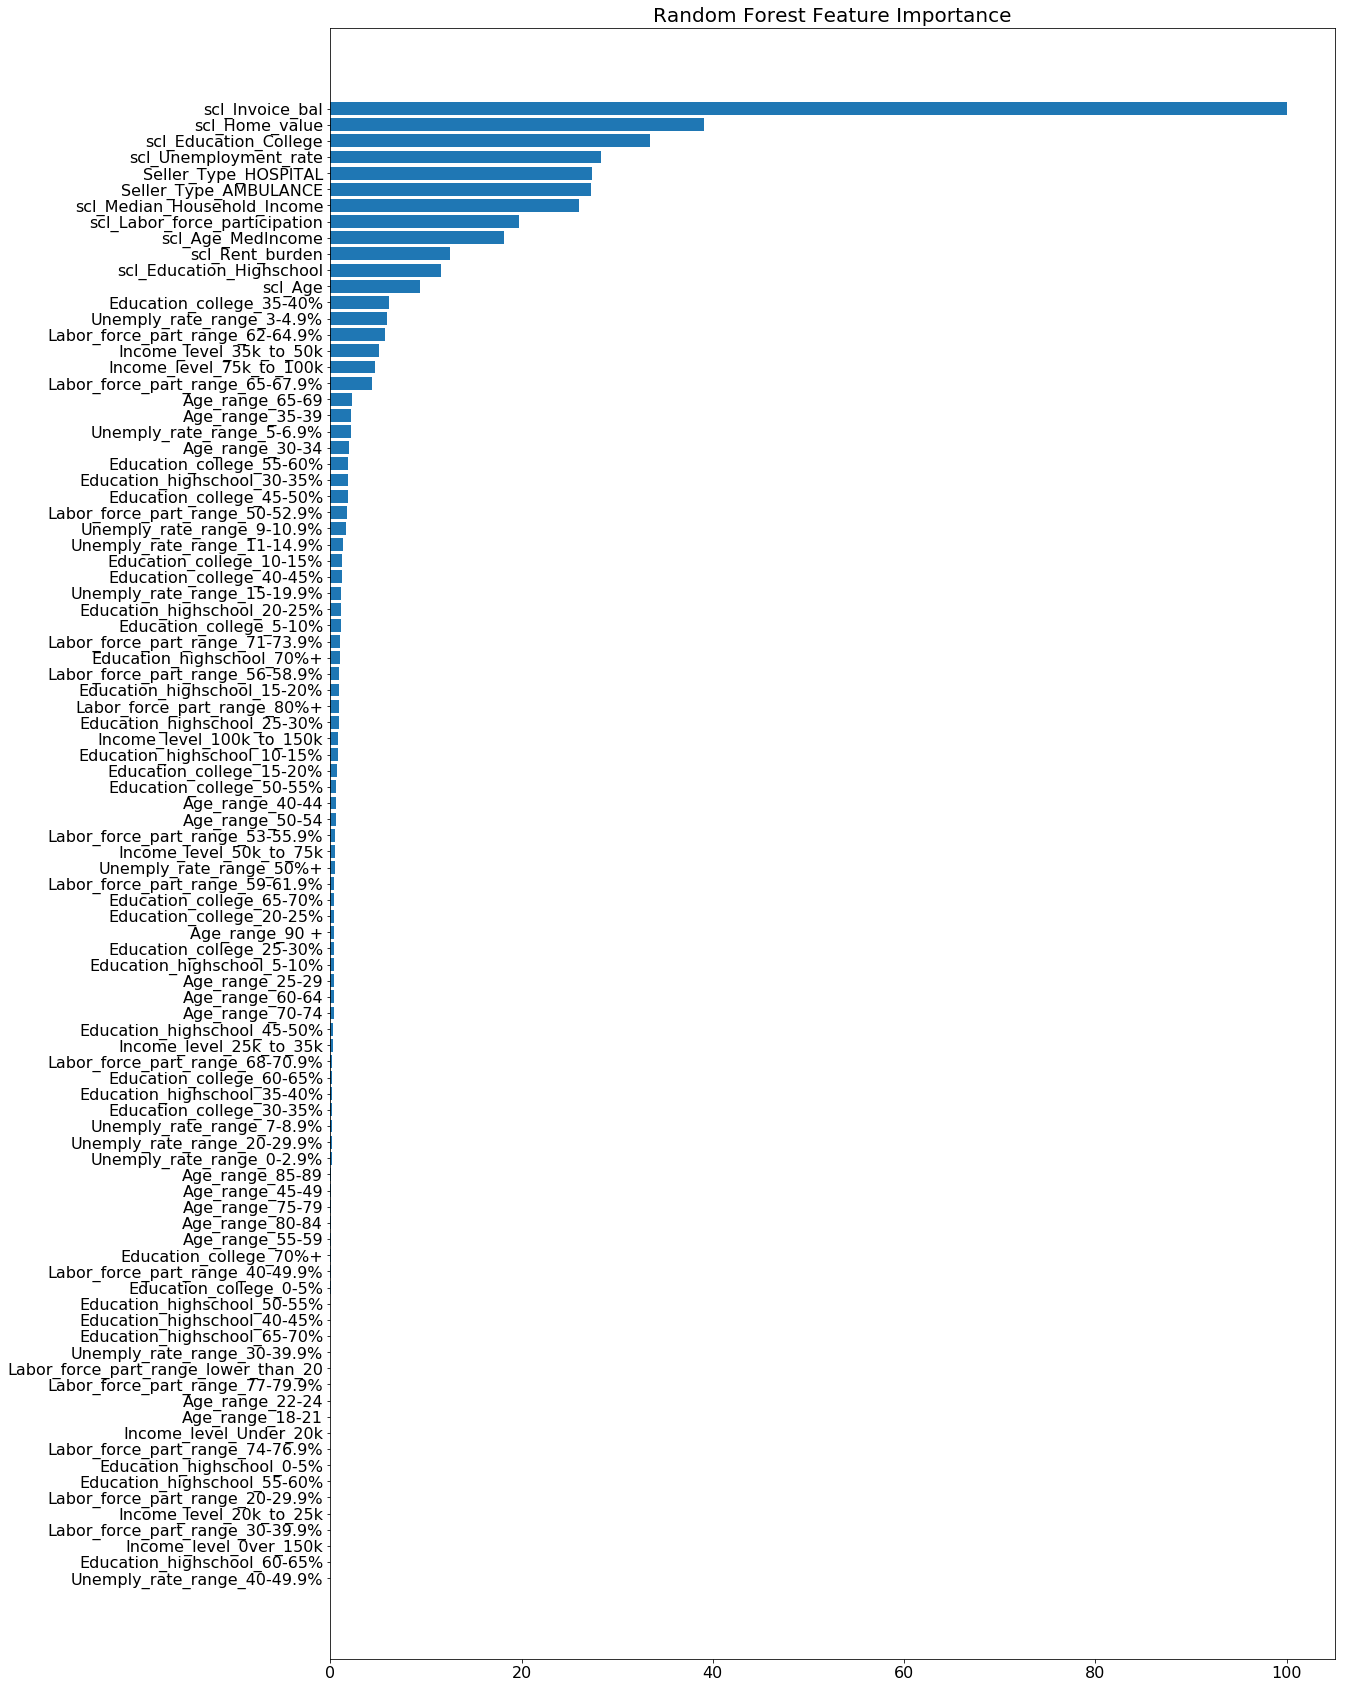

In [98]:
plt.figure(figsize=(18,30))
plt.barh(random.features, random.coef)
plt.title('Random Forest Feature Importance', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16);

# SMOTE Model 

In [99]:
from imblearn.over_sampling import SMOTE 

In [100]:
X_smote, y_smote = SMOTE().fit_sample(X_train, y_train)

In [101]:
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, random_state= 10, test_size=0.3)

In [102]:
pipe_rf = Pipeline([('pca', PCA(n_components=20, random_state=42)), 
                   ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

s_pipelines =  [pipe_rf]
s_names = ['Random Forest']
s_pipe_Model = []

# loop to fit each of the three pipelines
for i in s_pipelines: 
    print(i)
    i.fit(X_train_smote, y_train_smote)
    
for index, val in enumerate(s_pipelines): 
    print('%s pipeline train accuracy: %.3f' % (s_names[index], val.score(X_train_smote, y_train_smote)))
    print('%s pipeline test accuracy: %.3f' % (s_names[index], val.score(X_test_smote, y_test_smote)))
    
    score = s_names[index], val.score(X_train_smote, y_train_smote), val.score(X_test_smote, y_test_smote), 
    s_pipe_Model.append(score)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=20, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            m...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
Random Forest pipeline train accuracy: 0.672
Random Forest pipeline test accuracy: 0.641


In [104]:
s_model = pd.DataFrame.from_records(s_pipe_Model,  columns=['SMOTE Model', 'Train', 'Test'])
s_model

,SMOTE Model,Train,Test
0,Random Forest,0.672272,0.640839


In [103]:
#printing our classification report for all models
for index, val in enumerate(s_pipelines):
    print(f'{s_names[index]}:')
    print(classification_report(y_test, val.predict(X_test)))
    print('--------------------------------------------------------')

Random Forest:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       726
           1       0.63      0.65      0.64       774

   micro avg       0.62      0.62      0.62      1500
   macro avg       0.62      0.62      0.62      1500
weighted avg       0.62      0.62      0.62      1500

--------------------------------------------------------


# Feature Importance 

In [105]:
s_rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
s_rf.fit(X_train_smote, y_train_smote);

In [106]:
s_rf_imp = s_rf.feature_importances_

In [107]:
s_rf_list = []

for name, importance in zip(features, 100*(s_rf_imp/ s_rf_imp.max())):
    print(name, '=', importance)
    s_rf_list.append(importance)

Seller_Type_AMBULANCE = 26.21594319867995
Seller_Type_HOSPITAL = 17.765617744840714
Income_level_0ver_150k = 0.0
Income_level_100k_to_150k = 0.7218130269681418
Income_level_20k_to_25k = 0.0
Income_level_25k_to_35k = 1.7380712081380711
Income_level_35k_to_50k = 5.727147772970349
Income_level_50k_to_75k = 0.8022384054068515
Income_level_75k_to_100k = 2.252976954048304
Income_level_Under_20k = 0.0
Age_range_18-21 = 0.0
Age_range_22-24 = 0.0
Age_range_25-29 = 0.4822298501703369
Age_range_30-34 = 1.7163217247851223
Age_range_35-39 = 1.3624225376931736
Age_range_40-44 = 0.9171704489088806
Age_range_45-49 = 0.8305882158305081
Age_range_50-54 = 0.8704878356561427
Age_range_55-59 = 0.6109664576317436
Age_range_60-64 = 1.2263837787932306
Age_range_65-69 = 1.4801735504500086
Age_range_70-74 = 0.29434636932796104
Age_range_75-79 = 0.4478639006440825
Age_range_80-84 = 0.7272018043830447
Age_range_85-89 = 0.15742945464225022
Age_range_90 + = 0.15134581447343745
Unemply_rate_range_0-2.9% = 0.47052408

In [108]:
s_ft = pd.DataFrame(features.columns)
s_forest = pd.DataFrame(rf_list) 

s_random = pd.concat([ft, forest],axis=1)
s_random.columns = ['features', 'coef']
s_random = random.sort_values('coef', ascending=True)

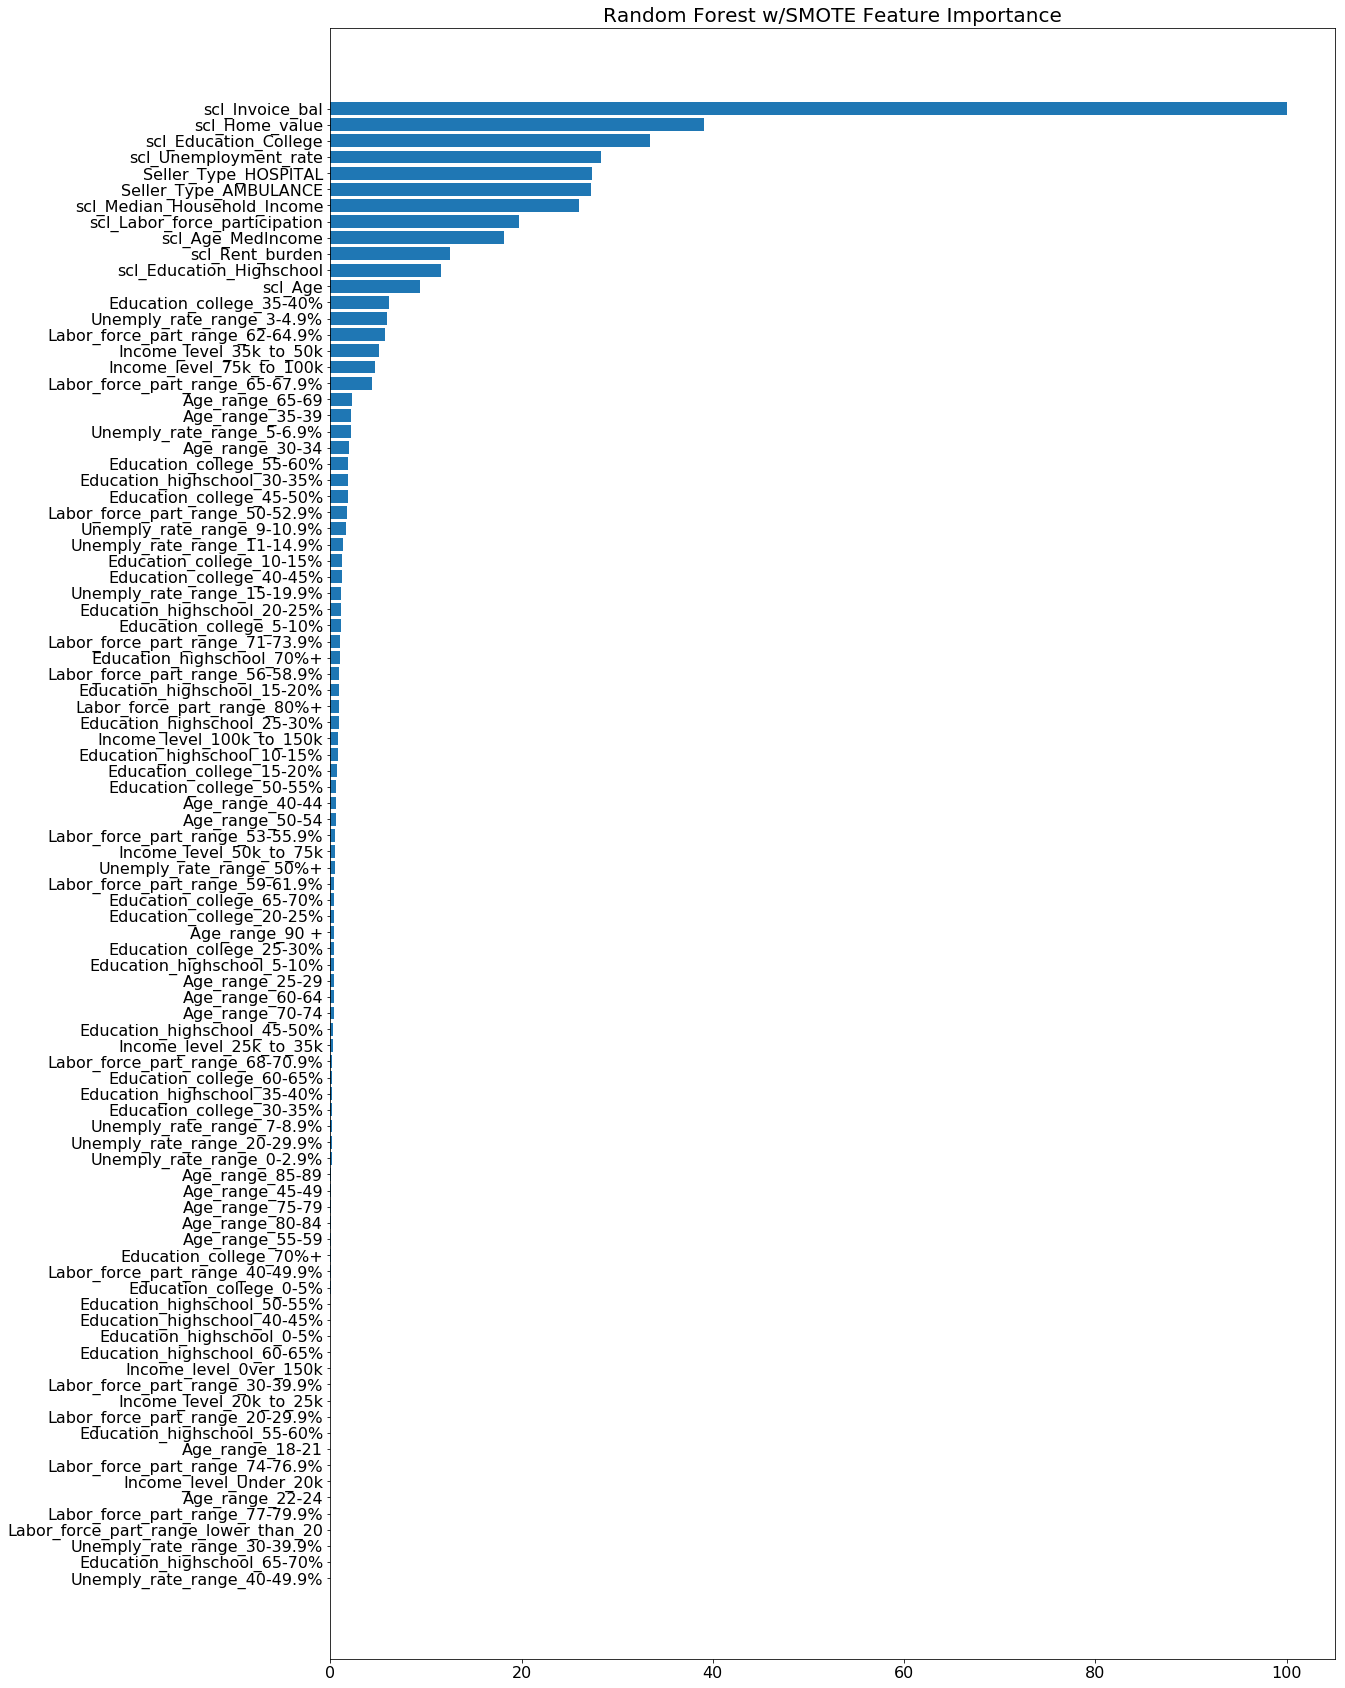

In [110]:
plt.figure(figsize=(18,30))
plt.barh(s_random.features, s_random.coef)
plt.title('Random Forest w/SMOTE Feature Importance', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16);